Import libraries

In [21]:
import pandas as pd
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np
from catboost import Pool
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import regex as re

Exploratory Analysis

ETL

In [22]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def preprocess_data(data):

    data['Title'] = data['Name'].apply(get_title)
    # Clean the variable Title.
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'noble')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Mrs')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    data['noble'] = data['Title'].apply(lambda x: 1  if x =='noble'  else 0)

    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)


    # Divide Fare in 10 levels
    n = 10
    data['Fare_level'] = pd.cut(data['Fare'], n, labels=np.arange(1,n+1))
    #data['Fare_range'] = pd.cut(data['Fare'], n)

    # get the last cabin if exists
    data['Last_cabin'] = data['Cabin'].apply(lambda x: str(x).split()[-1] if pd.notnull(x) else 'N')
    # get the Cabin_label of the last cabin
    pattern = r'([A-Za-z])'
    data['Cabin_label'] = data['Last_cabin'].apply(lambda x: re.search(pattern, str(x)).group(1) if x != 'N' else 'N')
    # Get the number of the last cabin if exists
    pattern = r'(\d+)'
    data['Cabin_number'] = data['Last_cabin'].apply(lambda x: re.search(pattern, str(x)) if x != 'N' else -1)
    # Get the number of distinct cabins reserved by the passenger.
    data['Cabin_count'] = data['Cabin'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    # drop not used columns and columns with NaN values.
    data.drop(columns = ['Cabin','Last_cabin', 'Cabin_number'], inplace = True)


    data.loc[data['Age'] <= 13, 'Age_group'] = 0 # kids
    data.loc[(data['Age'] > 13) & (data['Age'] <= 30), 'Age_group'] = 1 # young
    data.loc[(data['Age'] > 30) & (data['Age'] <= 45), 'Age_group'] = 2 # mature1
    data.loc[(data['Age'] > 45) & (data['Age'] <= 60), 'Age_group'] = 3 # old
    data.loc[(data['Age'] > 60) & (data['Age'] <= 100), 'Age_group'] = 4 # very old

    data['Companions'] = data['Ticket'].duplicated(keep=False).astype(int) * data.groupby('Ticket')['Ticket'].transform('count') -1 
    data.loc[data['Companions'] == -1, 'Companions'] = 0

    data.drop(['Name', 'Ticket'], axis=1, inplace=True)

    data['Sex'] = data['Sex'].map({'female': 1, 'male': 0})
    data = pd.get_dummies(data, columns=['Embarked'])
    data['FamilySize'] = data['SibSp'] + data['Parch']
    return data

In [23]:
train = pd.read_csv("train.csv", index_col=0)
train = preprocess_data(train)

y_train = train['Survived']
X_train = train.drop('Survived', axis=1)

len(X_train), len(y_train)

(891, 891)

In [24]:
test = pd.read_csv('test_with_survived.csv', index_col=0)
test = preprocess_data(test)

y_test = test['Survived']
X_test = test.drop(["Survived"], axis=1)

len(X_test), len(y_test)

(418, 418)

In [25]:
cat_features = np.where(X_train.dtypes != float)[0]
cat_features

array([ 0,  1,  3,  4,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16],
      dtype=int64)

In [26]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Title,noble,Fare_level,Cabin_label,Cabin_count,Age_group,Companions,Embarked_C,Embarked_Q,Embarked_S,FamilySize
PassengerId,,,,,,,,,,,,,,,,,
1,3,0,22.0,1,0,7.2500,Mr,0,1,N,0,1.0,0,0,0,1,1
2,1,1,38.0,1,0,71.2833,Mrs,0,2,C,1,2.0,0,1,0,0,1
3,3,1,26.0,0,0,7.9250,Miss,0,1,N,0,1.0,0,0,0,1,0
4,1,1,35.0,1,0,53.1000,Mrs,0,2,C,1,2.0,1,0,0,1,1
5,3,0,35.0,0,0,8.0500,Mr,0,1,N,0,2.0,0,0,0,1,0


Create a Model

In [28]:
# fit the model
model = CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy', verbose=False, use_best_model=True, random_seed=42, cat_features=cat_features)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

# make predictions
y_pred = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
accuracy # 0.7990430622009569, 0.794

0.7894736842105263

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       260
           1       0.72      0.72      0.72       158

    accuracy                           0.79       418
   macro avg       0.78      0.78      0.78       418
weighted avg       0.79      0.79      0.79       418



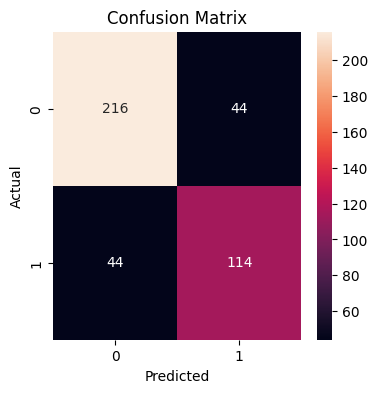

In [30]:
plt.figure(figsize = (4,4))
cm = sns.heatmap(confusion_matrix(y_test, y_pred), fmt='g', annot=True)
cm.set(title='Confusion Matrix')
cm.set(xlabel='Predicted', ylabel='Actual')
plt.show()

Hyperparameter Tuning

We are going to find the best parameters for the model using GridSearchCV. Also, we are going to use Cross Validation to avoid overfitting.

In [31]:
'''
cat_for_search = CatBoostClassifier(loss_function='Logloss',
                                    eval_metric='Accuracy',
                                    verbose=False,
                                    random_state=42)

params = {'depth': [2,3,4,5,6,7,8,9,10]}

'''
params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [100, 200, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7],
}
'''

grid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)

best_model = CatBoostClassifier(depth=grid['params']['depth'],
                                loss_function='Logloss',
                                eval_metric='Accuracy',
                                use_best_model=True,
                                random_seed=42,
                                verbose=False)

best_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))

accuracy_score(y_test, best_model.predict(X_test))
'''

"\n\ngrid = cat_for_search.grid_search(params, Pool(X_train, y_train, cat_features=cat_features), shuffle=True, cv=5, verbose=False,  plot=False)\n\nbest_model = CatBoostClassifier(depth=grid['params']['depth'],\n                                loss_function='Logloss',\n                                eval_metric='Accuracy',\n                                use_best_model=True,\n                                random_seed=42,\n                                verbose=False)\n\nbest_model.fit(X_train, y_train, cat_features=cat_features, eval_set = (X_test, y_test))\n\naccuracy_score(y_test, best_model.predict(X_test))\n"